**Importing all relevant libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import numpy as np
import sqlite3 as sql
import pandas as pd
import sklearn as sk
import sklearn.datasets
import sklearn.metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
import math
import joblib

import keras
# import pytorch as torch

Using TensorFlow backend.


**Parsing Data**


In [2]:
# Connecting to and establishing a cursor for our file
ratings_con = sql.connect("ratings.sqlite")
ratings_cur = ratings_con.cursor()
pd.set_option("display.max_columns", None)

game_data = pd.read_sql_query("SELECT * from games", ratings_con)
game_info = pd.read_sql_query("SELECT * from game_ratings", ratings_con)
ratings_con.close()  # closing the connection once we're finished parsing the data

game_database = game_data.merge(game_info, "outer")
game_datasets = np.array_split(game_database, 5)  # splitting dataset into 5 parts

**Data Pre-Processing**


In [3]:
training_dataset = pd.concat(
    (game_datasets[0], game_datasets[1], game_datasets[4], game_datasets[3])
)
testing_dataset = game_datasets[2]

train_with_IDs = training_dataset.drop(
    columns=["name_a", "name_b", "valid", "timestamp"]
)
test_with_IDs = testing_dataset.drop(columns=["name_a", "name_b", "valid", "timestamp"])

training_dataset = training_dataset.drop(
    columns=["name_a", "name_b", "valid", "timestamp", "id_a", "id_b"]
)
testing_dataset = testing_dataset.drop(
    columns=["name_a", "name_b", "valid", "timestamp", "id_a", "id_b"]
)

# print(training_dataset.info)
# print(testing_dataset.info)

training_labels = np.array(
    training_dataset.pop("winner").subtract(1).astype("category")
)
testing_labels = np.array(testing_dataset.pop("winner").subtract(1).astype("category"))

original_train_set = training_dataset.copy()
original_test_set = testing_dataset.copy()

one_hot_char_a = pd.get_dummies(original_train_set['char_a']).add_prefix('char_a_')
one_hot_char_b = pd.get_dummies(original_train_set['char_b']).add_prefix('char_b_')
one_hot_plat_a = pd.get_dummies(original_train_set['platform_a']).add_prefix('plat_a_')
one_hot_plat_b = pd.get_dummies(original_train_set['platform_b']).add_prefix('plat_b_')
one_hot_floor = pd.get_dummies(original_train_set['game_floor']).add_prefix('floor_')

original_train_set_one_hot = original_train_set.copy().drop(columns=["char_a", "platform_a", "char_b", "platform_b", "game_floor"])
original_train_set_one_hot = pd.concat([original_train_set_one_hot, one_hot_char_a, one_hot_char_b, one_hot_plat_a, one_hot_plat_b, one_hot_floor], axis=1)

one_hot_char_a = pd.get_dummies(original_test_set['char_a']).add_prefix('char_a_')
one_hot_char_b = pd.get_dummies(original_test_set['char_b']).add_prefix('char_b_')
one_hot_plat_a = pd.get_dummies(original_test_set['platform_a']).add_prefix('plat_a_')
one_hot_plat_b = pd.get_dummies(original_test_set['platform_b']).add_prefix('plat_b_')
one_hot_floor = pd.get_dummies(original_test_set['game_floor']).add_prefix('floor_')

original_test_set_one_hot = original_test_set.copy().drop(columns=["char_a", "platform_a", "char_b", "platform_b", "game_floor"])
original_test_set_one_hot = pd.concat([original_test_set_one_hot, one_hot_char_a, one_hot_char_b, one_hot_plat_a, one_hot_plat_b, one_hot_floor], axis=1)

elo_val_train = original_train_set.copy()
elo_val_train = elo_val_train.drop(columns=["char_a", "platform_a", "char_b", "platform_b", "game_floor"])
elo_train_np = elo_val_train.to_numpy()

elo_val_test = original_test_set.copy()
elo_val_test = elo_val_test.drop(columns=["char_a", "platform_a", "char_b", "platform_b", "game_floor"])
elo_test_np = elo_val_test.to_numpy()

scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(original_train_set)

normalized_training_data = scaler.transform(original_train_set)
normalized_testing_data = scaler.transform(original_test_set)

scaler.fit(original_train_set_one_hot)
normalized_training_data_one_hot = scaler.transform(original_train_set_one_hot)
normalized_testing_data_one_hot = scaler.transform(original_test_set_one_hot)

# print(normalized_testing_data_one_hot.shape)

normal_features = [
    "value_a",
    "value_b",
    "deviation_a",
    "deviation_b",
    "char_a",
    "char_b",
    "platform_a",
    "platform_b",
    "game_floor",
]
cat_features = ["char_a", "char_b", "platform_a", "platform_b", "game_floor"]

for feature in cat_features:
    training_dataset[feature] = training_dataset[feature].astype("category")
    testing_dataset[feature] = training_dataset[feature].astype("category")

train_data = lgb.Dataset(training_dataset, training_labels)
test_data = lgb.Dataset(testing_dataset, testing_labels)



**Binary Classifier: Determining Optimal Parameters**

*Code Taken From https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_simple.py and https://gist.github.com/shamilnabiyev/c1b6e23444a949bc45243eab445a3806*

In [4]:
# # # ----------------------------

# # # LIGHTGBM

# # # ----------------------------

# # # def objective(trial):
# # #     train_x, valid_x, train_y, valid_y = train_test_split(training_dataset, training_labels, test_size=0.25)
# # #     dtrain = lgb.Dataset(train_x, label=train_y)

# # #     param = {
# # #         "objective": "binary",
# # #         "metric": "binary_logloss",
# # #         "verbosity": -1,
# # #         "boosting_type": "gbdt",
# # #         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
# # #         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
# # #         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
# # #         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
# # #         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
# # #         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
# # #         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
# # #     }

# # #     gbm = lgb.train(param, dtrain)
# # #     preds = gbm.predict(valid_x)
# # #     pred_labels = np.rint(preds)
# # #     accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
# # #     return accuracy


# # # study_gbm = optuna.create_study(direction="maximize")
# # # study_gbm.optimize(objective, n_trials=100)

# # # print("Number of finished trials: {}".format(len(study_gbm.trials)))

# # # print("Best trial:")
# # # trial = study_gbm.best_trial

# # # print("  Value: {}".format(trial.value))

# # # print("  Params: ")
# # # for key, value in trial.params.items():
# # #     print("    {}: {}".format(key, value))

# # # ----------------------------

# # # RANDOM FOREST

# # # ----------------------------

# def objective(trial):
#     # Number of trees in random forest
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)

#     # Number of features to consider at every split
#     max_features = trial.suggest_categorical(name="max_features", choices=['auto', 'sqrt', None]) 

#     # Maximum number of levels in tree
#     max_depth = trial.suggest_int(name="max_depth", low=10, high=50, step=10)

#     # Minimum number of samples required to split a node
#     min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)

#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=10, high=50, step=10)
    
#     params = {
#         "n_estimators": n_estimators,
#         "max_features": max_features,
#         "max_depth": max_depth,
#         "min_samples_split": min_samples_split,
#         "min_samples_leaf": min_samples_leaf
#     }
#     model = sklearn.ensemble.RandomForestClassifier(random_state=0, **params)
    
#     cv_score = sklearn.model_selection.cross_val_score(model, normalized_training_data, training_labels, n_jobs=4, cv=5)
#     mean_cv_accuracy = cv_score.mean()
#     return mean_cv_accuracy


# study = optuna.create_study()
# study.optimize(objective, n_trials=5)



**Baseline Models: Glicko-2 & Coin Flips**

Reference: http://www.glicko.net/glicko/glicko.pdf

In [5]:

def g_func(rating1, rating2, dev1, dev2):
    deviationDifference = math.sqrt(pow(dev1, 2) + pow(dev2, 2))
    ratingDifference = (rating1-rating2)
    return deviationDifference*ratingDifference/400

def glickoEvaluator(training_np):
    # np array with columns [value_a, deviation_a, value_b, deviation_b]
    resultsList = []
    for i in range(0, training_np.shape[0]):
        probability_player_a_wins = pow(1+pow(10, -g_func(training_np[i][0],training_np[i][2],training_np[i][1],training_np[i][3])), -1)
        if (probability_player_a_wins > .5):
            resultsList.append(0)
        else:
            resultsList.append(1)
    return np.array(resultsList)

def coinFlip(training_np):
    resultsList = []
    rng = np.random.default_rng()
    for i in range(0, training_np.shape[0]):
        probability_player_a_wins = rng.random()
        if (probability_player_a_wins > .5):
            resultsList.append(0)
        else:
            resultsList.append(1)
    return np.array(resultsList)

print(f"Glicko Accuracy - Training: {sklearn.metrics.accuracy_score(training_labels, glickoEvaluator(elo_train_np))}")
print(f"Glicko Accuracy - Testing: {sklearn.metrics.accuracy_score(testing_labels, glickoEvaluator(elo_test_np))}")
print(f"Glicko Precision - Training: {sklearn.metrics.precision_score(training_labels, glickoEvaluator(elo_train_np))}")
print(f"Glicko Precision - Testing: {sklearn.metrics.precision_score(testing_labels, glickoEvaluator(elo_test_np))}")
print(f"Glicko Recall - Training: {sklearn.metrics.recall_score(training_labels, glickoEvaluator(elo_train_np))}")
print(f"Glicko Recall - Testing: {sklearn.metrics.recall_score(testing_labels, glickoEvaluator(elo_test_np))}")
print(f"Glicko F1 - Training: {sklearn.metrics.f1_score(training_labels, glickoEvaluator(elo_train_np))}")
print(f"Glicko F1 - Testing: {sklearn.metrics.f1_score(testing_labels, glickoEvaluator(elo_test_np))}")
print(f"Glicko ROC-AUC - Training: {sklearn.metrics.roc_auc_score(training_labels, glickoEvaluator(elo_train_np))}")
print(f"Glicko ROC-AUC - Testing: {sklearn.metrics.roc_auc_score(testing_labels, glickoEvaluator(elo_test_np))}")



print(f"Coin Flip Accuracy - Training: {sklearn.metrics.accuracy_score(training_labels, coinFlip(elo_train_np))}")
print(f"Coin Flip Accuracy - Testing: {sklearn.metrics.accuracy_score(testing_labels, coinFlip(elo_test_np))}")
print(f"Coin Flip Precision - Training: {sklearn.metrics.precision_score(training_labels, coinFlip(elo_train_np))}")
print(f"Coin Flip Precision - Testing: {sklearn.metrics.precision_score(testing_labels, coinFlip(elo_test_np))}")
print(f"Coin Flip Recall - Training: {sklearn.metrics.recall_score(training_labels, coinFlip(elo_train_np))}")
print(f"Coin Flip Recall - Testing: {sklearn.metrics.recall_score(testing_labels, coinFlip(elo_test_np))}")
print(f"Coin Flip F1 - Training: {sklearn.metrics.f1_score(training_labels, coinFlip(elo_train_np))}")
print(f"Coin Flip F1 - Testing: {sklearn.metrics.f1_score(testing_labels, coinFlip(elo_test_np))}")
print(f"Coin Flip ROC-AUC - Training: {sklearn.metrics.roc_auc_score(training_labels, coinFlip(elo_train_np))}")
print(f"Coin Flip ROC-AUC - Testing: {sklearn.metrics.roc_auc_score(testing_labels, coinFlip(elo_test_np))}")

Glicko Accuracy - Training: 0.6030175682507584
Glicko Accuracy - Testing: 0.6043225480283114
Glicko Precision - Training: 0.6058785131680892
Glicko Precision - Testing: 0.6035398230088496
Glicko Recall - Training: 0.6193716167336044
Glicko Recall - Testing: 0.6179713063176441
Glicko F1 - Training: 0.6125507683483056
Glicko F1 - Testing: 0.6106703146374829
Glicko ROC-AUC - Training: 0.6027967657618268
Glicko ROC-AUC - Testing: 0.6042636424962172
Coin Flip Accuracy - Training: 0.5001263902932255
Coin Flip Accuracy - Testing: 0.4983695652173913
Coin Flip Precision - Training: 0.507715482866438
Coin Flip Precision - Testing: 0.5005861067223892
Coin Flip Recall - Training: 0.5005924613964627
Coin Flip Recall - Testing: 0.5033475962748553
Coin Flip F1 - Training: 0.5043659969941608
Coin Flip F1 - Testing: 0.4999369403455669
Coin Flip ROC-AUC - Training: 0.5016933551158439
Coin Flip ROC-AUC - Testing: 0.49878683206081265


**Binary Classifier: LightGBM**


LightGBM Accuracy - Training: 0.6318092770475228
LightGBM Accuracy - Testing: 0.6070652173913044
LightGBM Precision - Training: 0.6334480343494017
LightGBM Precision - Testing: 0.6302571678374386
LightGBM Recall - Training: 0.6486454461546137
LightGBM Recall - Testing: 0.52617669267556
LightGBM F1 - Training: 0.6409566682997323
LightGBM F1 - Testing: 0.5735332446261266
LightGBM ROC-AUC - Training: 0.631581965257001
LightGBM ROC-AUC - Testing: 0.6074143173964243


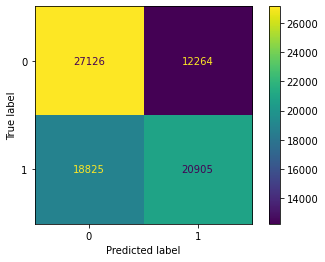

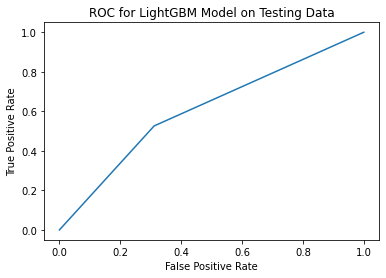

In [6]:
# num_round = 100
# params = {
#     'boosting': 'gbdt',
#     'objective': 'binary',
#     'metric': 'binary_logloss',
#     'learning_rate': .1,
#     'lambda_l1': 1.7996315262565406e-07,
#     'lambda_l2': 6.7220331293988386e-06,
#     'num_leaves': 70,
#     'feature_fraction': 0.7150629704058223,
#     'bagging_fraction': 0.7483911110218314,
#     'bagging_freq': 5,
#     'min_child_samples': 83,
# }

# bst = lgb.train(params, train_data, num_boost_round=num_round)
# bst.save_model('LightGBM_Classifier.txt', num_iteration=bst.best_iteration)

bst = lgb.Booster(model_file="LightGBM_Classifier.txt")
y_pred_test = bst.predict(testing_dataset)
y_pred_binary_test = [1 if pred > 0.5 else 0 for pred in y_pred_test]
y_pred_train = bst.predict(training_dataset)
y_pred_binary_train = [1 if pred > 0.5 else 0 for pred in y_pred_train]

print(
    f"LightGBM Accuracy - Training: {sklearn.metrics.accuracy_score(training_labels, y_pred_binary_train)}"
)
print(
    f"LightGBM Accuracy - Testing: {sklearn.metrics.accuracy_score(testing_labels, y_pred_binary_test)}"
)
print(
    f"LightGBM Precision - Training: {sklearn.metrics.precision_score(training_labels, y_pred_binary_train)}"
)
print(
    f"LightGBM Precision - Testing: {sklearn.metrics.precision_score(testing_labels, y_pred_binary_test)}"
)
print(
    f"LightGBM Recall - Training: {sklearn.metrics.recall_score(training_labels, y_pred_binary_train)}"
)
print(
    f"LightGBM Recall - Testing: {sklearn.metrics.recall_score(testing_labels, y_pred_binary_test)}"
)
print(
    f"LightGBM F1 - Training: {sklearn.metrics.f1_score(training_labels, y_pred_binary_train)}"
)
print(
    f"LightGBM F1 - Testing: {sklearn.metrics.f1_score(testing_labels, y_pred_binary_test)}"
)
print(
    f"LightGBM ROC-AUC - Training: {sklearn.metrics.roc_auc_score(training_labels, y_pred_binary_train)}"
)
print(
    f"LightGBM ROC-AUC - Testing: {sklearn.metrics.roc_auc_score(testing_labels, y_pred_binary_test)}"
)

confusion_matrix_test = sklearn.metrics.confusion_matrix(
    testing_labels, y_pred_binary_test
)

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix_test)
disp.plot()
plt.show()

fpr, tpr, thresholds = sklearn.metrics.roc_curve(testing_labels, y_pred_binary_test)
plt.plot(fpr,tpr)
plt.title('ROC for LightGBM Model on Testing Data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# accuracy_test = sklearn.metrics.accuracy_score(testing_labels, y_pred_binary_test)
# accuracy_train = sklearn.metrics.accuracy_score(training_labels, y_pred_binary_train)
# print(f"Accuracy-Train: {accuracy_train}")
# print(f"Accuracy-Test: {accuracy_test}")

# print(f"Log_Loss-Train: {sklearn.metrics.log_loss(training_labels, y_pred_train)}")
# print(f"Log_Loss-Test: {sklearn.metrics.log_loss(testing_labels, y_pred_test)}")

# print(f"ROC_AUC-Train: {sklearn.metrics.roc_auc_score(training_labels, y_pred_train)}")
# print(f"ROC_AUC-Test: {sklearn.metrics.roc_auc_score(testing_labels, y_pred_test)}")

# print(
#     f"Report-Train: \n{sklearn.metrics.classification_report(training_labels, y_pred_binary_train)}"
# )
# print(
#     f"Report-Test: \n{sklearn.metrics.classification_report(testing_labels, y_pred_binary_test)}")


# confusionMatrix_train = skplt.metrics.plot_confusion_matrix(
#     training_labels, y_pred_binary_train
# )
# plt.show()

# confusionMatrix_test = skplt.metrics.plot_confusion_matrix(
#     testing_labels, y_pred_binary_test
# )
# plt.show()

# precision_train = sklearn.metrics.precision_score(
#     training_labels, y_pred_binary_train, average=None
# )
# precision_test = sklearn.metrics.precision_score(
#     testing_labels, y_pred_binary_test, average=None
# )
# print(f"Precision-Train [type-1, type-2]: {precision_train}")
# print(f"Precision-Test [type-1, type-2]: {precision_test}")

**Assorted Binary Classifiers**

In [7]:
# Logistic Regression

# default_logReg = sklearn.linear_model.LogisticRegression()
# default_logReg.fit(original_train_set_one_hot, training_labels)
# joblib.dump(default_logReg, "logReg_default.pkl")

default_logReg = joblib.load("logReg_default.pkl")
default_logReg_pred_train = default_logReg.predict(original_train_set_one_hot)
default_logReg_pred_test = default_logReg.predict(original_test_set_one_hot)

print(f"default_logReg Accuracy - Training: {sklearn.metrics.accuracy_score(training_labels, default_logReg_pred_train)}")
print(f"default_logReg Accuracy - Testing: {sklearn.metrics.accuracy_score(testing_labels, default_logReg_pred_test)}")
print(f"default_logReg Precision - Training: {sklearn.metrics.precision_score(training_labels, default_logReg_pred_train)}")
print(f"default_logReg Precision - Testing: {sklearn.metrics.precision_score(testing_labels, default_logReg_pred_test)}")
print(f"default_logReg Recall - Training: {sklearn.metrics.recall_score(training_labels, default_logReg_pred_train)}")
print(f"default_logReg Recall - Testing: {sklearn.metrics.recall_score(testing_labels, default_logReg_pred_test)}")
print(f"default_logReg F1 - Training: {sklearn.metrics.f1_score(training_labels, default_logReg_pred_train)}")
print(f"default_logReg F1 - Testing: {sklearn.metrics.f1_score(testing_labels, default_logReg_pred_test)}")
print(f"default_logReg ROC-AUC - Training: {sklearn.metrics.roc_auc_score(training_labels, default_logReg_pred_train)}")
print(f"default_logReg ROC-AUC - Testing: {sklearn.metrics.roc_auc_score(testing_labels, default_logReg_pred_test)}")

# default_logReg_test_score = default_logReg.score(
#     original_test_set_one_hot, testing_labels
# )
# default_logReg_train_score = default_logReg.score(
#     original_train_set_one_hot, training_labels
# )
# print(
#     f"Logistic Regression - Accuracy-Train [No Normalization]: {default_logReg_train_score}"
# )
# print(
#     f"Logistic Regression - Accuracy-Test [No Normalization]: {default_logReg_test_score}"
# )
print("")
print("---------------------")
print("Normalization Applied")
print("---------------------")
print("")

# norm_logReg = sklearn.linear_model.LogisticRegression()
# norm_logReg.fit(normalized_training_data_one_hot, training_labels)
# joblib.dump(norm_logReg, "logReg_norm.pkl")

norm_logReg = joblib.load("logReg_norm.pkl")

norm_logReg_pred_train = norm_logReg.predict(normalized_training_data_one_hot)
norm_logReg_pred_test = norm_logReg.predict(normalized_testing_data_one_hot)

print(f"norm_logReg Accuracy - Training: {sklearn.metrics.accuracy_score(training_labels, norm_logReg_pred_train)}")
print(f"norm_logReg Accuracy - Testing: {sklearn.metrics.accuracy_score(testing_labels, norm_logReg_pred_test)}")
print(f"norm_logReg Precision - Training: {sklearn.metrics.precision_score(training_labels, norm_logReg_pred_train)}")
print(f"norm_logReg Precision - Testing: {sklearn.metrics.precision_score(testing_labels, norm_logReg_pred_test)}")
print(f"norm_logReg Recall - Training: {sklearn.metrics.recall_score(training_labels, norm_logReg_pred_train)}")
print(f"norm_logReg Recall - Testing: {sklearn.metrics.recall_score(testing_labels, norm_logReg_pred_test)}")
print(f"norm_logReg F1 - Training: {sklearn.metrics.f1_score(training_labels, norm_logReg_pred_train)}")
print(f"norm_logReg F1 - Testing: {sklearn.metrics.f1_score(testing_labels, norm_logReg_pred_test)}")
print(f"norm_logReg ROC-AUC - Training: {sklearn.metrics.roc_auc_score(training_labels, norm_logReg_pred_train)}")
print(f"norm_logReg ROC-AUC - Testing: {sklearn.metrics.roc_auc_score(testing_labels, norm_logReg_pred_test)}")

# norm_logReg_test_score = norm_logReg.score(
#     normalized_testing_data_one_hot, testing_labels
# )
# norm_logReg_train_score = norm_logReg.score(
#     normalized_training_data_one_hot, training_labels
# )
# print(
#     f"Logistic Regression - Accuracy-Train [Normalization]: {norm_logReg_train_score}"
# )
# print(f"Logistic Regression - Accuracy-Test [Normalization]: {norm_logReg_test_score}")

# # Random Forest
print("")
print("---------------------")
print("Random Forest")
print("---------------------")
print("")

# params = {
#     "n_estimators": 400,
#     "max_features": "auto",
#     "max_depth": 10,
#     "min_samples_split": 6,
#     "min_samples_leaf": 10,
# }

# rForest = sklearn.ensemble.RandomForestClassifier(random_state=0, **params)
# rForest.fit(normalized_training_data, training_labels)
# joblib.dump(rForest, "rForest.pkl")

rForest = joblib.load("rForest.pkl")
rForest_train_pred = rForest.predict(normalized_training_data)
rForest_test_pred = rForest.predict(normalized_testing_data)

print(f"rForest Accuracy - Training: {sklearn.metrics.accuracy_score(training_labels, rForest_train_pred)}")
print(f"rForest Accuracy - Testing: {sklearn.metrics.accuracy_score(testing_labels, rForest_test_pred)}")
print(f"rForest Precision - Training: {sklearn.metrics.precision_score(training_labels, rForest_train_pred)}")
print(f"rForest Precision - Testing: {sklearn.metrics.precision_score(testing_labels, rForest_test_pred)}")
print(f"rForest Recall - Training: {sklearn.metrics.recall_score(training_labels, rForest_train_pred)}")
print(f"rForest Recall - Testing: {sklearn.metrics.recall_score(testing_labels, rForest_test_pred)}")
print(f"rForest F1 - Training: {sklearn.metrics.f1_score(training_labels, rForest_train_pred)}")
print(f"rForest F1 - Testing: {sklearn.metrics.f1_score(testing_labels, rForest_test_pred)}")
print(f"rForest ROC-AUC - Training: {sklearn.metrics.roc_auc_score(training_labels, rForest_train_pred)}")
print(f"rForest ROC-AUC - Testing: {sklearn.metrics.roc_auc_score(testing_labels, rForest_test_pred)}")


default_logReg Accuracy - Training: 0.606780839231547
default_logReg Accuracy - Testing: 0.6075960566228513
default_logReg Precision - Training: 0.6093546304080315
default_logReg Precision - Testing: 0.6062504588727637
default_logReg Recall - Training: 0.6238181954249508
default_logReg Recall - Testing: 0.6235086836143972
default_logReg F1 - Training: 0.6165015932105196
default_logReg F1 - Testing: 0.6147584717896539
default_logReg ROC-AUC - Training: 0.6065508111344518
default_logReg ROC-AUC - Testing: 0.6075273806495443

---------------------
Normalization Applied
---------------------

norm_logReg Accuracy - Training: 0.607450707785642
norm_logReg Accuracy - Testing: 0.6076213346814965
norm_logReg Precision - Training: 0.6096064196571651
norm_logReg Precision - Testing: 0.6059223845647242
norm_logReg Recall - Training: 0.6263190061615985
norm_logReg Recall - Testing: 0.6252454064938334
norm_logReg F1 - Training: 0.6178497163879763
norm_logReg F1 - Testing: 0.6154322593432185
norm_lo

**Recurrent Neural Network**

In [8]:
# Note: for one-hot encoding, change all instances of '9' in the following functions to '77'

def createRNNModel():
    RNN_model = keras.models.Sequential()
    RNN_model.add(keras.layers.Dense(units=9, activation='relu', input_shape=(9,)))
    RNN_model.add(keras.layers.Dense(9, activation='relu'))
    RNN_model.add(keras.layers.Dense(9, activation='relu'))
    RNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
    adam = keras.optimizers.Adam(learning_rate=.001)
    RNN_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
    RNN_model.fit(normalized_training_data, training_labels, epochs=50)
    return RNN_model

# def lstm_data_transform(x_data, y_data, num_steps=5):
#     # Prepare the list for the transformed data
#     X, y = list(), list()
#     # Loop of the entire data set
#     for i in range(x_data.shape[0]):
#         # compute a new (sliding window) index
#         end_ix = i + num_steps
#         # if index is larger than the size of the dataset, we stop
#         if end_ix >= x_data.shape[0]:
#             break
#         # Get a sequence of data for x
#         seq_X = x_data[i:end_ix]
#         # Get only the last element of the sequency for y
#         seq_y = y_data[end_ix]
#         # Append the list with sequencies
#         X.append(seq_X)
#         y.append(seq_y)
#     # Make final arrays
#     x_array = np.array(X)
#     y_array = np.array(y)
#     return x_array, y_array


# look_back = 5
# tr_data, tr_results_data = lstm_data_transform(normalized_training_data, training_labels, look_back)


# def create_and_test_LSTM():
#     model = keras.models.Sequential()
#     model.add(keras.layers.LSTM(9, input_shape=(look_back, 9), return_sequences=True))
#     model.add(keras.layers.Dropout(.2))
#     model.add(keras.layers.LSTM(9, input_shape=(look_back, 9), return_sequences=True))
#     model.add(keras.layers.Dropout(.2))
#     model.add(keras.layers.LSTM(9, input_shape=(look_back, 9)))
#     model.add(keras.layers.Dropout(.2))
#     model.add(keras.layers.Dense(1))
#     adam = keras.optimizers.Adam(learning_rate=.001)
#     model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
#     # model.fit(normalized_training_data.reshape(normalized_training_data.shape[0], 1, normalized_training_data.shape[1]), training_labels, epochs=50)
#     model.fit(tr_data, tr_results_data, epochs=50)
#     model.save('LSTMModel_1')
#     return model
    

print(f"RNN Model - normal: ")
normRNN = keras.models.load_model('RNNModel.keras')
nRNN_pred_train = normRNN.predict(normalized_training_data)
nRNN_pred_train_bin = [1 if pred > 0.5 else 0 for pred in nRNN_pred_train]
nRNN_pred_test = normRNN.predict(normalized_testing_data)
nRNN_pred_test_bin = [1 if pred > 0.5 else 0 for pred in nRNN_pred_test]

print(f"RNN Model - normal Accuracy - Training: {sklearn.metrics.accuracy_score(training_labels, nRNN_pred_train_bin)}")
print(f"RNN Model - normal Accuracy - Testing: {sklearn.metrics.accuracy_score(testing_labels, nRNN_pred_test_bin)}")
print(f"RNN Model - normal Precision - Training: {sklearn.metrics.precision_score(training_labels, nRNN_pred_train_bin)}")
print(f"RNN Model - normal Precision - Testing: {sklearn.metrics.precision_score(testing_labels, nRNN_pred_test_bin)}")
print(f"RNN Model - normal Recall - Training: {sklearn.metrics.recall_score(training_labels, nRNN_pred_train_bin)}")
print(f"RNN Model - normal Recall - Testing: {sklearn.metrics.recall_score(testing_labels, nRNN_pred_test_bin)}")
print(f"RNN Model - normal F1 - Training: {sklearn.metrics.f1_score(training_labels, nRNN_pred_train_bin)}")
print(f"RNN Model - normal F1 - Testing: {sklearn.metrics.f1_score(testing_labels, nRNN_pred_test_bin)}")
print(f"RNN Model - normal ROC-AUC - Training: {sklearn.metrics.roc_auc_score(training_labels, nRNN_pred_train_bin)}")
print(f"RNN Model - normal ROC-AUC - Testing: {sklearn.metrics.roc_auc_score(testing_labels, nRNN_pred_test_bin)}")



print(f"RNN Model - one-hot: ")
hotRNN = keras.models.load_model('RNN_Model_one-hot.keras')
hotRNN_pred_train = hotRNN.predict(normalized_training_data_one_hot)
hotRNN_pred_train_bin = [1 if pred > 0.5 else 0 for pred in hotRNN_pred_train]
hotRNN_pred_test = hotRNN.predict(normalized_testing_data_one_hot)
hotRNN_pred_test_bin = [1 if pred > 0.5 else 0 for pred in hotRNN_pred_test]

print(f"RNN Model - one-hot Accuracy - Training: {sklearn.metrics.accuracy_score(training_labels, hotRNN_pred_train_bin)}")
print(f"RNN Model - one-hot Accuracy - Testing: {sklearn.metrics.accuracy_score(testing_labels, hotRNN_pred_test_bin)}")
print(f"RNN Model - one-hot Precision - Training: {sklearn.metrics.precision_score(training_labels, hotRNN_pred_train_bin)}")
print(f"RNN Model - one-hot Precision - Testing: {sklearn.metrics.precision_score(testing_labels, hotRNN_pred_test_bin)}")
print(f"RNN Model - one-hot Recall - Training: {sklearn.metrics.recall_score(training_labels, hotRNN_pred_train_bin)}")
print(f"RNN Model - one-hot Recall - Testing: {sklearn.metrics.recall_score(testing_labels, hotRNN_pred_test_bin)}")
print(f"RNN Model - one-hot F1 - Training: {sklearn.metrics.f1_score(training_labels, hotRNN_pred_train_bin)}")
print(f"RNN Model - one-hot F1 - Testing: {sklearn.metrics.f1_score(testing_labels, hotRNN_pred_test_bin)}")
print(f"RNN Model - one-hot ROC-AUC - Training: {sklearn.metrics.roc_auc_score(training_labels, hotRNN_pred_train_bin)}")
print(f"RNN Model - one-hot ROC-AUC - Testing: {sklearn.metrics.roc_auc_score(testing_labels, hotRNN_pred_test_bin)}")





# model = create_and_test_LSTM()
# model.save('LSTMModel')
# print(f"LSTM Model - normal: ")
# testModel(keras.models.load_model('LSTM_Model.keras'), False)
# print(f"LSTM Model - one-hot: ")
# testModel(keras.models.load_model('LSTM_Model_one-hot.keras'), True)

RNN Model - normal: 
RNN Model - normal Accuracy - Training: 0.6071789686552073
RNN Model - normal Accuracy - Testing: 0.6072674418604651
RNN Model - normal Precision - Training: 0.6105560328955444
RNN Model - normal Precision - Testing: 0.6073031061751655
RNN Model - normal Recall - Training: 0.6204255743757328
RNN Model - normal Recall - Testing: 0.6166121318902592
RNN Model - normal F1 - Training: 0.6154512385241642
RNN Model - normal F1 - Testing: 0.6119222170877618
RNN Model - normal ROC-AUC - Training: 0.607000120982348
RNN Model - normal ROC-AUC - Testing: 0.6072271118958785
RNN Model - one-hot: 
RNN Model - one-hot Accuracy - Training: 0.6417435540950455
RNN Model - one-hot Accuracy - Testing: 0.5916582406471182
RNN Model - one-hot Precision - Training: 0.6542217493810377
RNN Model - one-hot Precision - Testing: 0.597781408094435
RNN Model - one-hot Recall - Training: 0.621267493202285
RNN Model - one-hot Recall - Testing: 0.57102944877926
RNN Model - one-hot F1 - Training: 0.6